# Her skal vi undersøke dataen hentet og bruke Pandas/SQL for å forstå strukturen

### Her begynner vi med å forstå dataen fra frost bedre, og gjøre det om til en pandas dataframe, slik at det blir lett å jobbe med videre. 

I tillegg skal vi se på hvordan vi kan bruke pandasql (sqldf) for å gjøre querys på dataen og filtrere gjennom lettvint. Vi begynner med å hente file_path

In [1]:
import pandas as pd
from pandasql import sqldf
import os

# Henter file path

notebook_directory = os.getcwd()
root = os.path.abspath(os.path.join(notebook_directory, ".."))
file_path = os.path.join(root, "data", "Frost_Observations.json")



Dataen vi hentet er laget med mange dictionaries, som igjen inneholder flere dictionaries. For å kun få ut relevant data kan vi filtrere gjennom python for enkelte "entries" i forskjellige dictionaries. Deretter kan vi gjøre det om til en dataframe ved bruk av pandas og se hvordan dataen ser ut

In [2]:
import json

with open(file_path,"r") as fil: #leser filen og lagrer den som "data"
    data=json.load(fil)

# filtrerer dataen for bare det som er relevant til å analysere
brukbar_data = [
    {
        "elementId": obs["elementId"],
        "sourceId": entry["sourceId"],
        "referenceTime": entry["referenceTime"],
        "value": obs["value"],
        "unit": obs["unit"]
    }
    for entry in data["data"]
    for obs in entry["observations"] 
]

df=pd.DataFrame(brukbar_data) #Dataframe

pd.set_option('display.max_columns', None) #justerer output display
pd.set_option('display.width', 1000)
print(df.head())

                       elementId   sourceId             referenceTime  value     unit
0    mean(relative_humidity P1D)  SN18700:0  2020-04-01T00:00:00.000Z   56.0  percent
1  sum(precipitation_amount P1D)  SN18700:0  2020-04-01T00:00:00.000Z    0.0       mm
2  sum(precipitation_amount P1D)  SN18700:0  2020-04-01T00:00:00.000Z    0.0       mm
3           mean(wind_speed P1D)  SN18700:0  2020-04-01T00:00:00.000Z    2.6      m/s
4      mean(air_temperature P1D)  SN18700:0  2020-04-01T00:00:00.000Z    6.4     degC


Da har vi fått lagd en dataframe med pandas som viser relevant data. Det ser litt uryddig ut og det passer bedre å ha hver observasjon som kolonner og så verdiene nedover, så vi kan bruke pd.pivot til til å gjøre det mer ryddig. 

Men det at vi har 2 verdier for mean(air_temperature P1D) og for sum(precipitation_amount P1D) gjør at dette ikke fungerer. Foreløpig kan vi kombinere det ved å ta gjennomsnittsverdien av de 2 målte, slik at vi kan visualisere dataframen bedre. Vi kan bruke "groupby" funksjonen for å samle de 2 identiske elementene og slå sammen verdiene med gjennomsnittet. 

In [3]:
rader=[]

# henter relevant data ved å iterere gjennom i forskjellige dictionaries
for entry in data["data"]:
    referenceTime = entry["referenceTime"]
    for obs in entry["observations"]:
         rader.append({
            "referenceTime": referenceTime,
            "elementId": obs["elementId"],
            "value": obs["value"],
        })
         
df=pd.DataFrame(rader) #dataframe

# slår sammen der det er 2 av mean(air_temperature P1D) og tar gjennomsnittet, 
# gjør pivot av dataframe, slik at kolonnene blir type observasjon

df_gruppering = df.groupby(["referenceTime", "elementId"], as_index=False)["value"].mean()
df2=df_gruppering.pivot(index="referenceTime",columns="elementId",values="value")
df2=df2.reset_index()
print(df2.head())



elementId             referenceTime  mean(air_temperature P1D)  mean(relative_humidity P1D)  mean(wind_speed P1D)  sum(precipitation_amount P1D)
0          2020-04-01T00:00:00.000Z                       6.15                         56.0                   2.6                           0.00
1          2020-04-02T00:00:00.000Z                       4.75                         63.0                   4.7                           0.35
2          2020-04-03T00:00:00.000Z                       3.60                         36.0                   4.3                           0.35
3          2020-04-04T00:00:00.000Z                       2.90                         49.0                   3.4                           0.00
4          2020-04-05T00:00:00.000Z                       4.65                         90.0                   1.9                           1.10


In [20]:
# lagrer df2 som json fil for videre bruk
df2.to_json('../data/df2_data.json',indent=4)

Her ser vi dataen på en mer forståelig måte. Det er verdt å merke at "boolean_clear_sky_weather(cloud_area_fraction P1D)" er boolean verdier, så i datahåndteringen kan vi ta hensyn til det og omgjøre det fra float. 

## Bruker PANDAS SQL (sqldf) til å hente data fra DataFrame

Nå som vi har en fungerende DataFrame, kan vi hente diverse type data og spesifikk data ved bruk av Pandas SQL/sqldf: 

1) Gjennomsnittlig temperatur for Juli i årene tilgjengelig
2) Alle dager der 24 timers gjennomsnittstemperaturen er over 20 grader og der det ikke var skyete basert på "boolean_clear_sky_weather..."

In [6]:
pysqldf = lambda q: sqldf(q, globals())

query = """

    SELECT strftime('%Y',referenceTime) AS År,
    AVG("mean(air_temperature P1D)") AS avg_temperatur_juli
    FROM df2
    WHERE strftime('%m',referenceTime) = '07'
    GROUP BY År
"""
resultat=pysqldf(query)
print(resultat)

     År  avg_temperatur_juli
0  2020            14.993548
1  2021            19.930645
2  2022            17.524194
3  2023            16.337097
4  2024            16.812903


Her har vi for hele tidsperioden vi har i flere år:

In [21]:
query = """
    SELECT strftime('%Y-%m', referenceTime) AS Month, 
           AVG("mean(air_temperature P1D)") AS avg_temperature
    FROM df2
    GROUP BY Month
    ORDER BY Month;
"""
result = sqldf(query, globals())
print(result)

      Month  avg_temperature
0   2020-04         7.338333
1   2020-05        10.000000
2   2020-06        18.853333
3   2020-07        14.993548
4   2021-04         5.673333
5   2021-05        10.430645
6   2021-06        17.291667
7   2021-07        19.930645
8   2022-04         6.256667
9   2022-05        11.390323
10  2022-06        16.585000
11  2022-07        17.524194
12  2023-04         5.981667
13  2023-05        11.830645
14  2023-06        18.948333
15  2023-07        16.337097
16  2024-04         5.673333
17  2024-05        16.025806
18  2024-06        15.316667
19  2024-07        16.812903


In [7]:
query2="""
    SELECT * FROM df2
    WHERE "mean(air_temperature P1D)">=20.0
    ORDER BY "mean(air_temperature P1D)" DESC;
"""
resultat=pysqldf(query2)
print(resultat)

               referenceTime  mean(air_temperature P1D)  mean(relative_humidity P1D)  mean(wind_speed P1D)  sum(precipitation_amount P1D)
0   2023-06-17T00:00:00.000Z                      24.60                         36.0                   1.9                           0.00
1   2020-06-19T00:00:00.000Z                      24.15                         49.0                   2.7                           0.00
2   2023-06-16T00:00:00.000Z                      24.00                         43.0                   2.2                           0.00
3   2023-06-15T00:00:00.000Z                      23.55                         44.0                   1.7                           0.00
4   2020-06-27T00:00:00.000Z                      23.50                         59.0                   1.8                           0.05
5   2020-06-20T00:00:00.000Z                      23.35                         63.0                   3.2                           0.25
6   2020-06-16T00:00:00.000Z      

## Omgjøring av luftkvalitet-data til panda dataframe + forståelse: 

Her skal vi sortere gjennom luftkvalitetsdataen. Vi henter file-path og gjør om til data frame med pandas

In [8]:
import pandas as pd
from pandasql import sqldf
import os

# Henter file path

notebook_directory = os.getcwd()
root = os.path.abspath(os.path.join(notebook_directory, ".."))
file_path_L = os.path.join(root, "data", "luftkvalitet_Kirkeveien_all_years.json")


Først kan vi hente generell informasjon om det som ligger i filen, og lager en dataframe basert på geneerell info, som stasjon, område, hva vi måler og id: 

In [9]:
import json

with open(file_path_L,"r") as fil: #leser filen og lagrer den som "data"
    luftdata=json.load(fil)

general_data = []
for entry in luftdata:
    # Extract general information
    general_info = {
        "id": entry.get("id"),
        "zone": entry.get("zone"),
        "municipality": entry.get("municipality"),
        "area": entry.get("area"),
        "station": entry.get("station"),
        "component": entry.get("component"),
        "unit": entry.get("unit"),
        "latitude": entry.get("latitude"),
        "longitude": entry.get("longitude"),
    }
    
    # Extract values (nested list of dictionaries)
    for value in entry.get("values", []):
        # Combine general info with each value
        row = general_info.copy()
        row.update(value)  # Add fields from the "values" dictionary
        general_data.append(row)

# Create a DataFrame
df1 = pd.DataFrame(general_data)

# Display the first few rows
print(df1.head())

   id       zone municipality  area     station component   unit  latitude  longitude                   dateTime      value  count  coverage
0  21  Stor-Oslo         Oslo  Oslo  Kirkeveien       NO2  µg/m³  59.93231   10.72455  2020-04-01T00:00:00+01:00  22.176800     23        96
1  21  Stor-Oslo         Oslo  Oslo  Kirkeveien       NO2  µg/m³  59.93231   10.72455  2020-04-02T00:00:00+01:00  12.066933     24       100
2  21  Stor-Oslo         Oslo  Oslo  Kirkeveien       NO2  µg/m³  59.93231   10.72455  2020-04-03T00:00:00+01:00   5.252476     24       100
3  21  Stor-Oslo         Oslo  Oslo  Kirkeveien       NO2  µg/m³  59.93231   10.72455  2020-04-04T00:00:00+01:00   9.445686     24       100
4  21  Stor-Oslo         Oslo  Oslo  Kirkeveien       NO2  µg/m³  59.93231   10.72455  2020-04-05T00:00:00+01:00  15.043523     24       100


In [10]:
processed_data = []
for entry in luftdata:
    component = entry.get("component")  # e.g., NO2, PM10, etc.
    for value_entry in entry.get("values", []):
        # Extract date and value
        processed_data.append({
            "date": value_entry.get("dateTime"),  # Assuming "fromTime" is the date field
            "component": component,
            "value": value_entry.get("value")  # Assuming "value" is the observed value
        })

# Create a DataFrame
df = pd.DataFrame(processed_data)

# Pivot the DataFrame to have components as columns
pivot_df = df.pivot(index="date", columns="component", values="value")

# Reset the index to make it easier to work with
pivot_df.reset_index(inplace=True)
pivot_df["date"] = pd.to_datetime(pivot_df["date"], errors="coerce").dt.tz_localize(None)

print(pivot_df.head())

component       date        CO        NO        NO2        NOx       PM10      PM2.5
0         2020-04-01  0.265466  6.311852  22.176800  31.821309  26.698062   7.374793
1         2020-04-02  0.196590  2.667235  12.066933  16.142468  17.272707   4.935823
2         2020-04-03  0.257888  2.052685   5.252476   8.388978  10.126831   1.303536
3         2020-04-04  0.234627  2.732509   9.445686  13.620960  11.561105   3.290720
4         2020-04-05  0.311696  2.664206  15.043523  19.114429  23.980191  15.100590


In [19]:
# Lagrer filen som "df1_data.json"

pivot_df.to_json('../data/df1_data.json',indent=4)

Her er et eksempel på bruk av sqldf for å hente data fra dataframe om luftkvalitet: 

- Total gjennomsnittlig verdi for de forskjellige partikkelmålingene

In [23]:
query = """
    SELECT 
        AVG("NO2") AS avg_NO2,
        AVG("PM10") AS avg_PM10,
        AVG("PM2.5") AS avg_PM25,
        AVG("CO") AS avg_CO,
        AVG("NO") AS avg_NO,
        AVG("NOx") AS avg_NOx
    FROM pivot_df
"""
result = pysqldf(query)
print(result)

    avg_NO2   avg_PM10  avg_PM25    avg_CO    avg_NO    avg_NOx
0  9.366441  11.309867  5.173862  0.195032  2.770652  13.599998


## Her kan vi lage noen enkle plotter for å eksperimentere og se hvordan det kan se ut

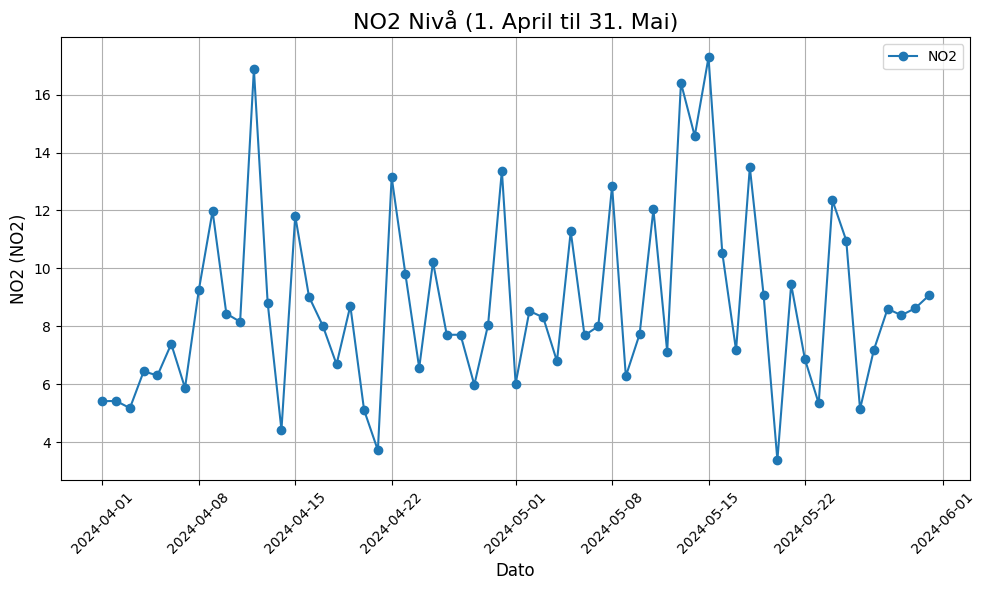

In [24]:
import matplotlib.pyplot as plt

# bruker pivot_df filtrerer for dato område
pivot_df["date"] = pd.to_datetime(pivot_df["date"]) 
filtered_df = pivot_df[(pivot_df["date"] >= "2024-04-01") & (pivot_df["date"] <= "2024-05-31")]


# Velger variabel
variable = "NO2"

# Plotter
plt.figure(figsize=(10, 6))
plt.plot(filtered_df["date"], filtered_df[variable], marker="o", label=variable)

# Customize the plot
plt.title(f"{variable} Nivå (1. April til 31. Mai)", fontsize=16)
plt.xlabel("Dato", fontsize=12)
plt.ylabel(f"{variable} ({pivot_df[variable].name})", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

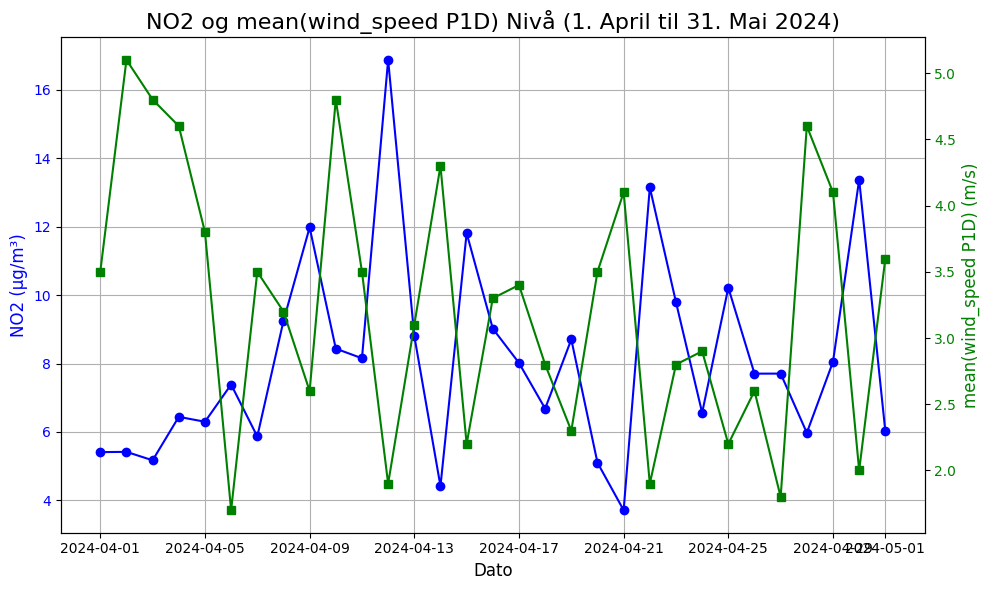

In [17]:
import pandas as pd
import matplotlib.pyplot as plt



# Gjør at begge dataframes er i datetime format
pivot_df["date"] = pd.to_datetime(pivot_df["date"])
df2["referenceTime"] = pd.to_datetime(df2["referenceTime"])
df2["referenceTime"]=df2["referenceTime"].dt.tz_localize(None) #Fjerner UTC tidsformat fra Df2

# Gir start dato og sluttdato for grafen
start_date = "2024-04-01"
end_date = "2024-05-01"
filtered_pivot_df = pivot_df[(pivot_df["date"] >= start_date) & (pivot_df["date"] <= end_date)]
filtered_df2 = df2[(df2["referenceTime"] >= start_date) & (df2["referenceTime"] <= end_date)]

# Merge dataframes
merged_df = pd.merge(
    filtered_pivot_df,
    filtered_df2,
    left_on="date",
    right_on="referenceTime",
    how="inner"
)

# Variabler som plottes
variable1 = "NO2"  # Fra pivot_df
variable2 = "mean(wind_speed P1D)"  # Fra df2

#Lager figur, x aksen
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotter første variabel på y aksen
ax1.plot(merged_df["date"], merged_df[variable1], marker="o", color="blue", label=variable1)
ax1.set_xlabel("Dato", fontsize=12)
ax1.set_ylabel(f"{variable1} (µg/m³)", fontsize=12, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

# Lager ny akse for vindhastighet
ax2 = ax1.twinx()
ax2.plot(merged_df["date"], merged_df[variable2], marker="s", color="green", label=variable2)
ax2.set_ylabel(f"{variable2} (m/s)", fontsize=12, color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Tittel osv
plt.title(f"{variable1} og {variable2} Nivå (1. April til 31. Mai 2024)", fontsize=16)
fig.tight_layout()

plt.show()